# **CatarAction**

##Import Module

In [ ]:
# TensorFlow
import tensorflow as tf

# Helper Libraries
import numpy as np
import pandas as pd
import os
import random
import pathlib
import shutil
import tensorflow_hub as hub
from shutil import copyfile
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.preprocessing import image

from os import getcwd
from absl import logging
logging.set_verbosity(logging.ERROR)

print('\u2022 Using TensorFlow Version:', tf.__version__)
print('\u2022 GPU Device Found.' if tf.config.list_physical_devices('GPU') else '\u2022 GPU Device Not Found. Running on CPU')

• Using TensorFlow Version: 2.12.0
• GPU Device Found.


In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##Import and Modify datasets

In [ ]:
!mkdir -p ~/.kaggle
!echo '{"username":"farahtrin","key":"23e7f71da0f70be102ea7a9741c8550b"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d nandanp6/cataract-image-dataset --unzip

100% 502M/503M [00:27<00:00, 20.2MB/s]
100% 503M/503M [00:27<00:00, 19.4MB/s]


##Manage the Datases Folder

In [ ]:
def move_data(source_path, destination_path):
    try:
        shutil.move(source_path, destination_path)
        print("The data has been successfully moved.")
    except FileNotFoundError:
        print("The source file or folder cannot be found.")
    except PermissionError:
        print("No permission to move the data.")
    except Exception as e:
        print(f"An error occurred.: {str(e)}")

source = '/content/processed_images/train/cataract'  # Path of the source file or folder
destination = '/content/processed_images'  # Destination folder path

move_data(source, destination)

An error occurred.: Destination path '/content/processed_images/cataract' already exists


In [ ]:
source = '/content/processed_images/test/cataract'  # Path of the source file or folder
destination = '/content/processed_images/cataract'  # Destination folder path

move_data(source, destination)

The data has been successfully moved.


In [ ]:
source = '/content/processed_images/train/normal'  # Path of the source file or folder
destination = '/content/processed_images/'  # Destination folder path

move_data(source, destination)

An error occurred.: Destination path '/content/processed_images/normal' already exists


In [ ]:
source = '/content/processed_images/test/normal'  # Path of the source file or folder
destination = '/content/processed_images/normal'  # Destination folder path

move_data(source, destination)

The data has been successfully moved.


In [ ]:
def rename_files(folder_path, old_name, new_name):
    for filename in os.listdir(folder_path):
        if filename == old_name:
            old_file_path = os.path.join(folder_path, filename)
            new_file_path = os.path.join(folder_path, new_name)
            os.rename(old_file_path, new_file_path)
            print(f"File {old_name} renamed to {new_name}")


folder_path = '/content/processed_images/cataract/cataract'
old_name = 'image_246.png'
new_name = 'image_307.png'

rename_files(folder_path, old_name, new_name)

File image_246.png renamed to image_307.png


In [ ]:
folder_path = '/content/processed_images/cataract/cataract'
old_name = 'image_247.png'
new_name = 'image_308.png'

rename_files(folder_path, old_name, new_name)

File image_247.png renamed to image_308.png


In [ ]:
def move_data_from_subfolder(subfolder_path, main_folder_path):
     # Retrieve all files and subfolders within the subfolder
    items = os.listdir(subfolder_path)

    # Move the file from the subfolder to the main folder
    for item in items:
        item_path = os.path.join(subfolder_path, item)
        destination_path = os.path.join(main_folder_path, item)
        shutil.move(item_path, destination_path)

    # Delete the subfolder
    shutil.rmtree(subfolder_path)

subfolder_path = '/content/processed_images/cataract/cataract'
main_folder_path = '/content/processed_images/cataract'

move_data_from_subfolder(subfolder_path, main_folder_path)


In [ ]:
subfolder_path = '/content/processed_images/normal/normal'
main_folder_path = '/content/processed_images/normal'

move_data_from_subfolder(subfolder_path, main_folder_path)

In [ ]:
# Set the path to the processed_images folder
processed_images_folder = '/content/processed_images'

# Delete the train and test folders
shutil.rmtree(os.path.join(processed_images_folder, 'train'))
shutil.rmtree(os.path.join(processed_images_folder, 'test'))

##Recheck the amount of data in the folder

In [ ]:
source_path_cataract = '/content/processed_images/cataract'
source_path_normal = '/content/processed_images/normal'

# os.listdir returns a list containing all files under the given path
print(f"There are {len(os.listdir(source_path_cataract))} images of cataract.")
print(f"There are {len(os.listdir(source_path_normal))} images of normal.")

There are 306 images of cataract.
There are 306 images of normal.


## Splitting into 3 set, Train, Validation, and Test

In [ ]:
# Define root directory
root_dir = '/content/cataract-v-normal'

# Empty directory to prevent FileExistsError if the function is run several times
if os.path.exists(root_dir):
    shutil.rmtree(root_dir)

# Create_train_val_test_dirs
def create_train_val_test_dirs(root_path):
    os.makedirs(os.path.join(root_path, 'training', 'cataract'))
    os.makedirs(os.path.join(root_path, 'training', 'normal'))
    os.makedirs(os.path.join(root_path, 'validation', 'cataract'))
    os.makedirs(os.path.join(root_path, 'validation', 'normal'))
    os.makedirs(os.path.join(root_path, 'test', 'cataract'))
    os.makedirs(os.path.join(root_path, 'test', 'normal'))

try:
    create_train_val_test_dirs(root_path=root_dir)
except FileExistsError:
    print("You should not be seeing this since the upper directory is removed beforehand")

# Create the required directory structure
print(f"Directory structure created in {root_dir}")

Directory structure created in /content/cataract-v-normal


In [ ]:
for rootdir, dirs, files in os.walk(root_dir):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))

/content/cataract-v-normal/validation
/content/cataract-v-normal/test
/content/cataract-v-normal/training
/content/cataract-v-normal/validation/cataract
/content/cataract-v-normal/validation/normal
/content/cataract-v-normal/test/cataract
/content/cataract-v-normal/test/normal
/content/cataract-v-normal/training/cataract
/content/cataract-v-normal/training/normal


In [ ]:
def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, TEST_DIR, SPLIT_SIZE):
    all_files = []

    for file_name in os.listdir(SOURCE_DIR):
        file_path = os.path.join(SOURCE_DIR, file_name)

        if os.path.getsize(file_path):
            all_files.append(file_name)
        else:
            print('{} is zero length, so ignoring'.format(file_name))

    n_files = len(all_files)
    split_point_1 = int(n_files * SPLIT_SIZE[0])
    split_point_2 = int(n_files * (SPLIT_SIZE[0] + SPLIT_SIZE[1]))

    shuffled = random.sample(all_files, n_files)

    train_set = shuffled[:split_point_1]
    validation_set = shuffled[split_point_1:split_point_2]
    test_set = shuffled[split_point_2:]

    for file_name in train_set:
        copyfile(os.path.join(SOURCE_DIR, file_name), os.path.join(TRAINING_DIR, file_name))

    for file_name in validation_set:
        copyfile(os.path.join(SOURCE_DIR, file_name), os.path.join(VALIDATION_DIR, file_name))

    for file_name in test_set:
        copyfile(os.path.join(SOURCE_DIR, file_name), os.path.join(TEST_DIR, file_name))

In [ ]:
CATARACT_SOURCE_DIR = "/content/processed_images/cataract/"
NORMAL_SOURCE_DIR = "/content/processed_images/normal/"

TRAINING_DIR = "/content/cataract-v-normal/training"
VALIDATION_DIR = "/content/cataract-v-normal/validation"
TEST_DIR = "/content/cataract-v-normal/test"

TRAINING_CATARACT_DIR = os.path.join(TRAINING_DIR, "cataract/")
VALIDATION_CATARACT_DIR = os.path.join(VALIDATION_DIR, "cataract/")
TEST_CATARACT_DIR = os.path.join(TEST_DIR, "cataract/")

TRAINING_NORMAL_DIR = os.path.join(TRAINING_DIR, "normal/")
VALIDATION_NORMAL_DIR = os.path.join(VALIDATION_DIR, "normal/")
TEST_NORMAL_DIR = os.path.join(TEST_DIR, "normal/")

# Empty directories in case you run this cell multiple times
if len(os.listdir(TRAINING_CATARACT_DIR)) > 0:
    for file in os.scandir(TRAINING_CATARACT_DIR):
        os.remove(file.path)
if len(os.listdir(TRAINING_NORMAL_DIR)) > 0:
    for file in os.scandir(TRAINING_NORMAL_DIR):
        os.remove(file.path)
if len(os.listdir(VALIDATION_CATARACT_DIR)) > 0:
    for file in os.scandir(VALIDATION_CATARACT_DIR):
        os.remove(file.path)
if len(os.listdir(VALIDATION_NORMAL_DIR)) > 0:
    for file in os.scandir(VALIDATION_NORMAL_DIR):
        os.remove(file.path)
if len(os.listdir(TEST_CATARACT_DIR)) > 0:
    for file in os.scandir(TEST_CATARACT_DIR):
        os.remove(file.path)
if len(os.listdir(TEST_NORMAL_DIR)) > 0:
    for file in os.scandir(TEST_NORMAL_DIR):
        os.remove(file.path)

# Define proportion of images used for training, validation, and testing
split_size = [0.6, 0.2, 0.2]

# Run the function
# NOTE: Messages about zero length images should be printed out
split_data(CATARACT_SOURCE_DIR, TRAINING_CATARACT_DIR, VALIDATION_CATARACT_DIR, TEST_CATARACT_DIR, split_size)
split_data(NORMAL_SOURCE_DIR, TRAINING_NORMAL_DIR, VALIDATION_NORMAL_DIR, TEST_NORMAL_DIR, split_size)

# Your function should perform copies rather than moving images so original directories should contain unchanged images
print(f"\n\nOriginal cataract's directory has {len(os.listdir(CATARACT_SOURCE_DIR))} images")
print(f"Original normal's directory has {len(os.listdir(NORMAL_SOURCE_DIR))} images\n")

# Training, validation, and testing splits. Check that the number of images matches the expected output.
print(f"There are {len(os.listdir(TRAINING_CATARACT_DIR))} images of cataract for training")
print(f"There are {len(os.listdir(TRAINING_NORMAL_DIR))} images of normal for training")
print(f"There are {len(os.listdir(VALIDATION_CATARACT_DIR))} images of cataract for validation")
print(f"There are {len(os.listdir(VALIDATION_NORMAL_DIR))} images of normal for validation")
print(f"There are {len(os.listdir(TEST_CATARACT_DIR))} images of cataract for testing")
print(f"There are {len(os.listdir(TEST_NORMAL_DIR))} images of normal for testing")




Original cataract's directory has 306 images
Original normal's directory has 306 images

There are 183 images of cataract for training
There are 183 images of normal for training
There are 61 images of cataract for validation
There are 61 images of normal for validation
There are 62 images of cataract for testing
There are 62 images of normal for testing


In [ ]:
image_paths = {
    "train_cataract": [],
    "train_normal": [],
    "validation_cataract": [],
    "validation_normal": [],
    "test_cataract": [],
    "test_normal": []
}

for dirname, _, filenames in os.walk('/content/cataract-v-normal'):
    for filename in filenames:
        path = os.path.join(dirname, filename)
        if "training/cataract" in path:
            image_paths["train_cataract"].append(path)
        elif "training/normal" in path:
            image_paths["train_normal"].append(path)
        elif "validation/cataract" in path:
            image_paths["validation_cataract"].append(path)
        elif "validation/normal" in path:
            image_paths["validation_normal"].append(path)
        elif "test/cataract" in path:
            image_paths["test_cataract"].append(path)
        elif "test/normal" in path:
            image_paths["test_normal"].append(path)

##Normal eye sampling

size of image : (774, 978, 3)


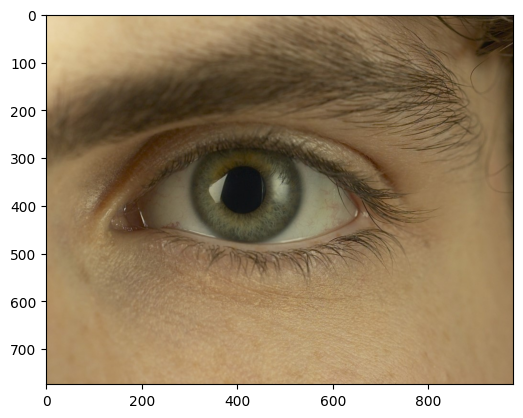

In [ ]:
sample_img = np.array(Image.open(image_paths["validation_normal"][1]))
print(f"size of image : {np.shape(sample_img)}")
plt.imshow(sample_img)

##Cataract eye sampling

size of image : (2528, 3684, 3)


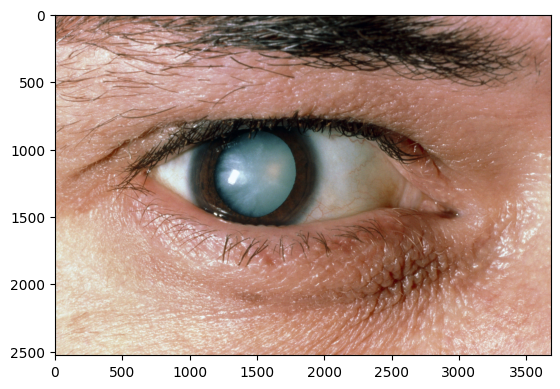

In [ ]:
sample_img = np.array(Image.open(image_paths["validation_cataract"][1]))
print(f"size of image : {np.shape(sample_img)}")
plt.imshow(sample_img)

##Data Augmentation

In [ ]:
# Create data generator for training and validation

IMAGE_SHAPE = (224, 224)

datagen_kwargs = dict(rescale=1./255)

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    VALIDATION_DIR,
    shuffle=True,
    target_size=IMAGE_SHAPE)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
train_generator = train_datagen.flow_from_directory(
    TRAINING_DIR,
    shuffle=True,
    target_size=IMAGE_SHAPE)

testing_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
testing_generator = testing_datagen.flow_from_directory(
    TEST_DIR,
    shuffle=True,
    batch_size=124,
    target_size=IMAGE_SHAPE)




Found 122 images belonging to 2 classes.
Found 366 images belonging to 2 classes.
Found 124 images belonging to 2 classes.


In [ ]:
# Learn more about data batches

image_batch_train, label_batch_train = next(iter(train_generator))
print("Image batch shape: ", image_batch_train.shape)
print("Label batch shape: ", label_batch_train.shape)

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 2)


In [ ]:
# Learn about dataset labels

dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

['Cataract' 'Normal']


##Modelling

In [ ]:
model = tf.keras.Sequential([
  hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4",
                 output_shape=[1280],
                 trainable=False),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])
model.build([None, 224, 224, 3])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dropout_2 (Dropout)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])

In [ ]:
# Run model training
hist= model.fit(
    train_generator,
    epochs=10,
    verbose=1,
    validation_data=valid_generator).history

Epoch 1/10
12/12 [==============================] - 24s 1s/step - loss: 0.6565 - acc: 0.7104 - val_loss: 0.3348 - val_acc: 0.8607
Epoch 2/10
12/12 [==============================] - 14s 1s/step - loss: 0.3726 - acc: 0.8497 - val_loss: 0.2154 - val_acc: 0.9262
Epoch 3/10
12/12 [==============================] - 14s 1s/step - loss: 0.3008 - acc: 0.8743 - val_loss: 0.1680 - val_acc: 0.9426
Epoch 4/10
12/12 [==============================] - 14s 1s/step - loss: 0.2245 - acc: 0.9180 - val_loss: 0.1524 - val_acc: 0.9426
Epoch 5/10
12/12 [==============================] - 13s 1s/step - loss: 0.1919 - acc: 0.9344 - val_loss: 0.1347 - val_acc: 0.9590
Epoch 6/10
12/12 [==============================] - 16s 1s/step - loss: 0.1915 - acc: 0.9098 - val_loss: 0.1263 - val_acc: 0.9508
Epoch 7/10
12/12 [==============================] - 13s 1s/step - loss: 0.1555 - acc: 0.9454 - val_loss: 0.1207 - val_acc: 0.9508
Epoch 8/10
12/12 [==============================] - 13s 1s/step - loss: 0.1317 - acc: 0.95

In [ ]:
# Measure accuracy and loss after training

final_loss, final_accuracy = model.evaluate(valid_generator)

4/4 [==============================] - 3s 812ms/step - loss: 0.1082 - acc: 0.9590


In [ ]:
print("Final loss: {:.2f}".format(final_loss))
print("Final accuracy: {:.2f}%".format(final_accuracy * 100))

Final loss: 0.11
Final accuracy: 95.90%


# Plotting

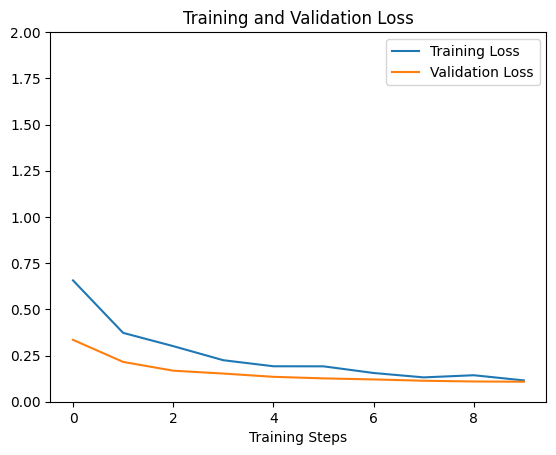

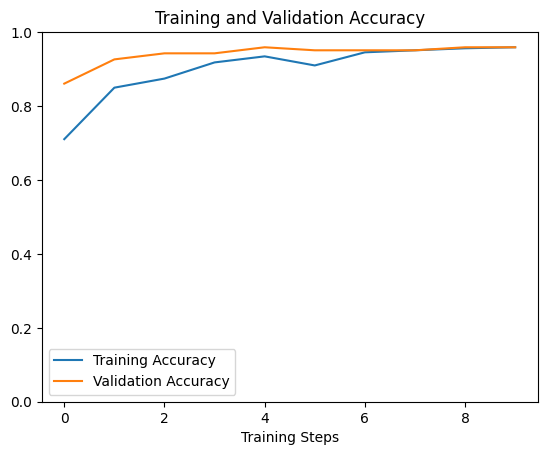

In [ ]:
# Visualize training process

plt.figure()
plt.title('Training and Validation Loss')
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"], label='Training Loss')
plt.plot(hist["val_loss"], label='Validation Loss')
plt.legend()

plt.figure()
plt.title('Training and Validation Accuracy')
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["acc"], label='Training Accuracy')
plt.plot(hist["val_acc"], label='Validation Accuracy')
plt.legend()
plt.show()

# Evaluation

In [ ]:
CATARACT_SAVED_MODEL = "saved_models/cataract"
tf.saved_model.save(model, CATARACT_SAVED_MODEL)

In [ ]:
# Load SavedModel
cataract_model = hub.load(CATARACT_SAVED_MODEL)
print(cataract_model)

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7fc1906124a0>


In [ ]:
# Get images and labels batch from test dataset generator
test_image_batch, test_label_batch = next(iter(testing_generator))
true_label_ids = np.argmax(test_label_batch, axis=-1)

print("Testing batch shape:", test_image_batch.shape)

Testing batch shape: (124, 224, 224, 3)


In [ ]:
tf_model_predictions = cataract_model(test_image_batch)
print("Prediction results shape:", tf_model_predictions.shape)

Prediction results shape: (124, 2)


In [ ]:
# Convert prediction results to Pandas dataframe, for better visualization

tf_pred_dataframe = pd.DataFrame(tf_model_predictions.numpy())
tf_pred_dataframe.columns = dataset_labels

print("Prediction results for the first elements")
tf_pred_dataframe.head()

Prediction results for the first elements


,Cataract,Normal
0,0.801775,0.198225
1,0.985842,0.014158
2,0.908856,0.091144
3,0.986525,0.013475
4,0.998624,0.001376


In [ ]:
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]

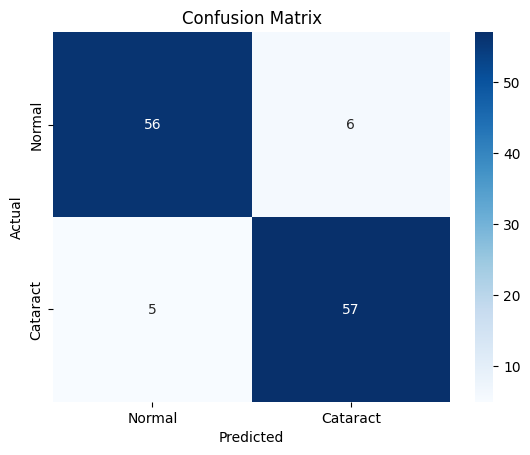

In [ ]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_label_ids, predicted_ids)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5], ['Normal', 'Cataract'])
plt.yticks([0.5, 1.5], ['Normal', 'Cataract'])
plt.show()

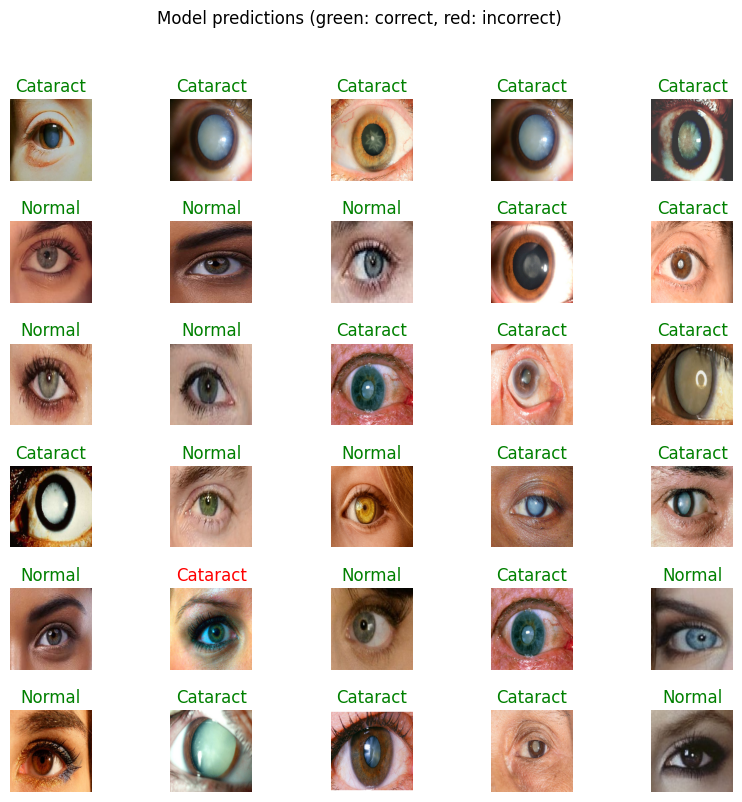

In [ ]:
# Print images batch and labels predictions

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(test_image_batch[n])
  color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

#Exporting to TFLite and .h5

In [ ]:
# Select mode of optimization
mode = "A"

if mode == 'Storage':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
    optimization = tf.lite.Optimize.DEFAULT

# Use the TFLiteConverter SavedModel API to initialize the converter
converter = tf.lite.TFLiteConverter.from_saved_model(CATARACT_SAVED_MODEL)

# Set the optimzations
converter.optimizations = [optimization]

# Invoke the converter to finally generate the TFLite model
tflite_model = converter.convert();

tflite_model_file = pathlib.Path('./model.tflite')
tflite_model_file.write_bytes(tflite_model)

2529088

In [ ]:
from tensorflow.keras.models import load_model

# Save the model in .h5 format.
model.save('model.h5')